## PFSA


In [1]:
import matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import argparse
from pathlib import Path
from scipy import stats
import re

plt.rcParams["font.family"] = "Times New Roman"


def get_experiment_name(x):
    """Extract experiment name from grammar name."""
    return x.split("_")[0]


def get_seed(x):
    """Extract seed from grammar name if it exists."""
    if "seed" in x:
        return int(re.search(r"seed(\d+)", x).group(1))
    return None


def get_window(x):
    """Extract window size from grammar name if it exists."""
    if "window" in x:
        return int(re.search(r"window(\d+)", x).group(1))
    return None


exp_name = "local_entropy_XXX"
results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/PFSA/{exp_name}/collected_results_test.csv"
# results_path = f"/Users/agiats/Projects/lm_inductive_bias/results/{exp_name}/collected_results_test_larger_m.csv"

architectures = [
    "lstm",
    "transformer",
    "stack-rnn_lstm_superposition-20",
    "stack-transformer_32-2.superposition-32.2",
    "stack-rnn_lstm_512_superposition-64",
    "stack-transformer_768-2.superposition-64.2",
]
architecture_labels = [
    "LSTM",
    "Transformer",
    "RNN+Sup. 20",
    "Tf+Sup. 32",
    "RNN+Sup. 64",
    "Tf+Sup. 64",
]


df = pd.read_csv(results_path)
df["experiment_name"] = df["grammar_name"].apply(get_experiment_name)
df["seed"] = df["grammar_name"].apply(get_seed)
df["window"] = df["grammar_name"].apply(get_window)

architecture_map = dict(zip(architectures, architecture_labels))
df["KL_divergence"] = df["cross_entropy_per_token_base_2"] - df["next_symbol_entropy"]


# TODO: delete this

# df = df[df["KL_divergence"] < 0.2]

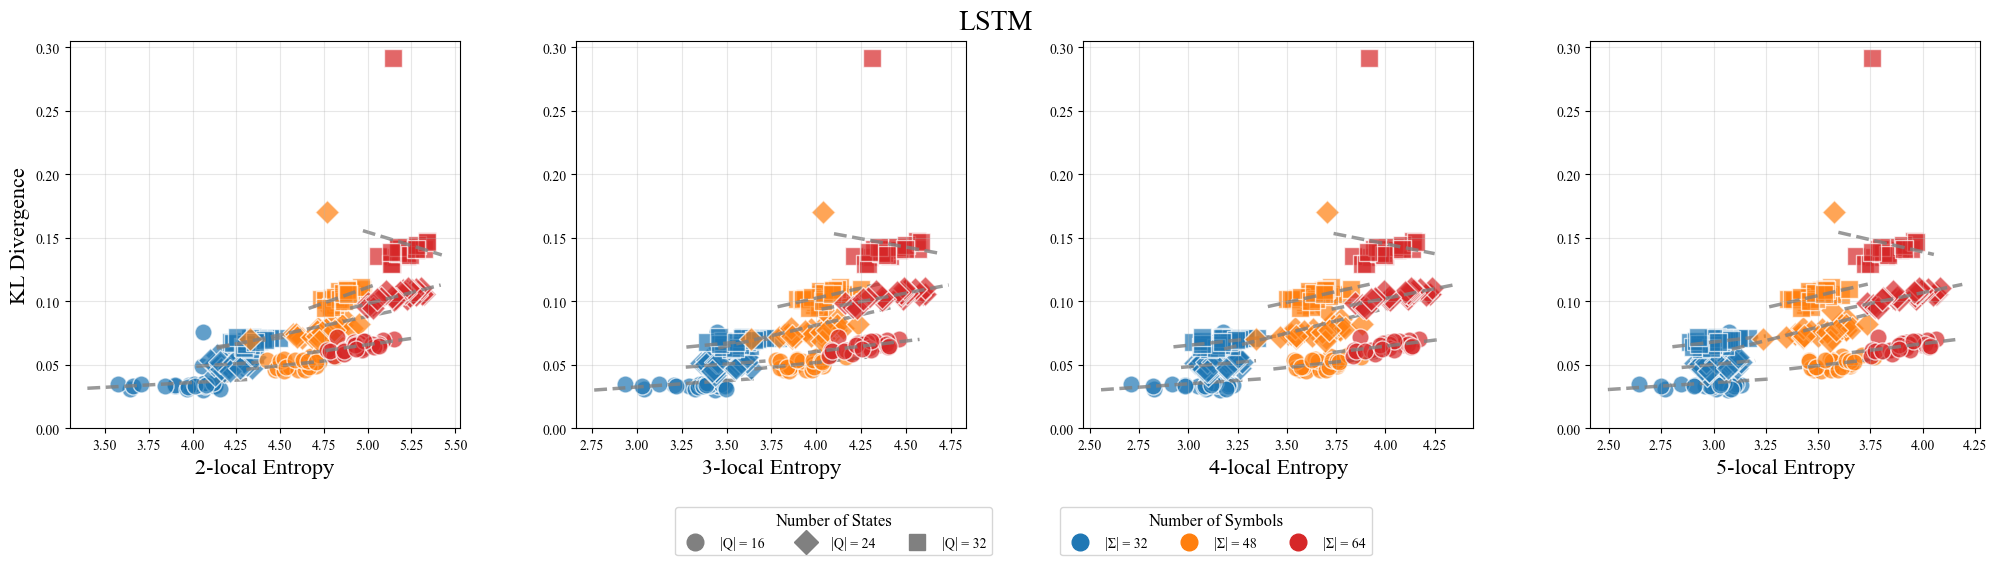

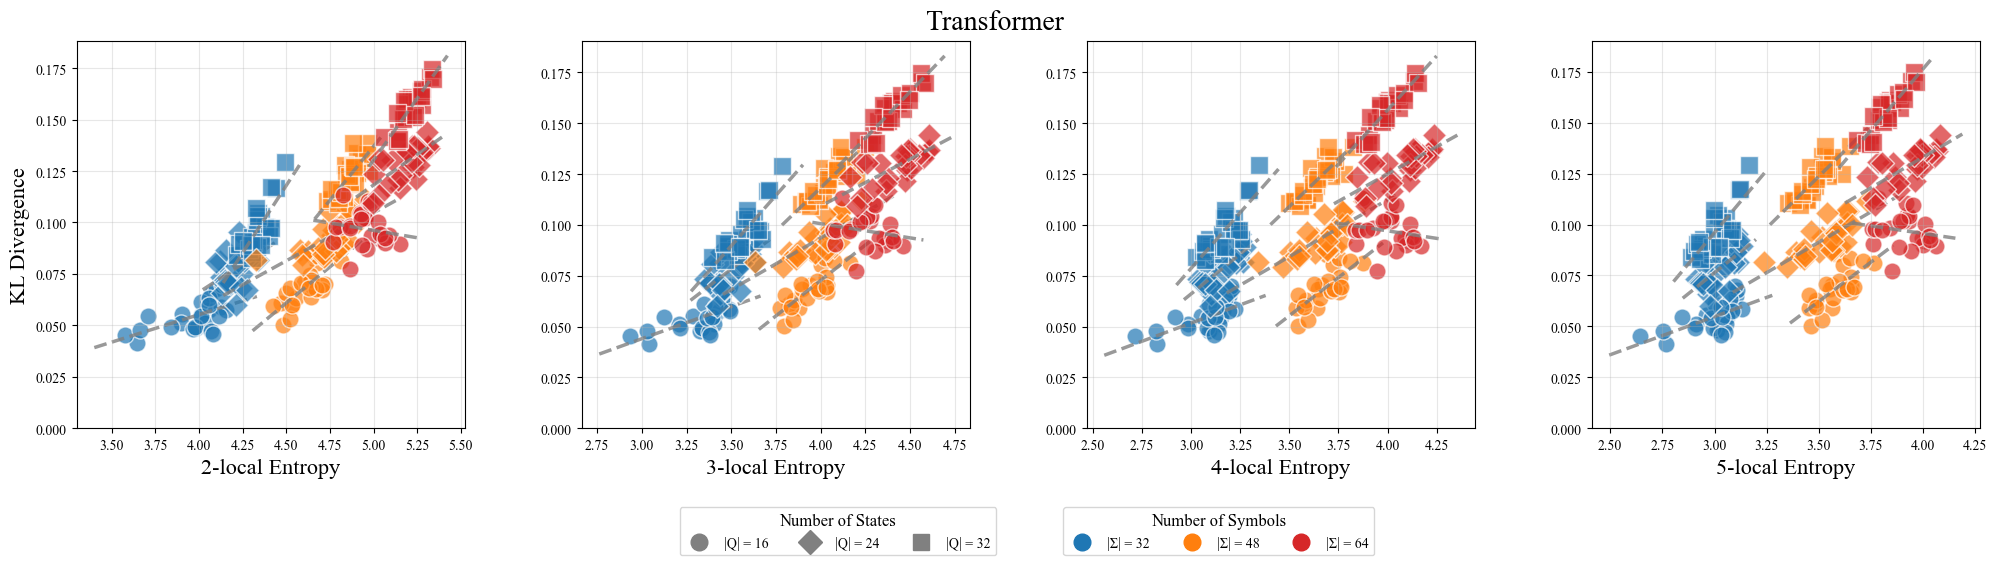

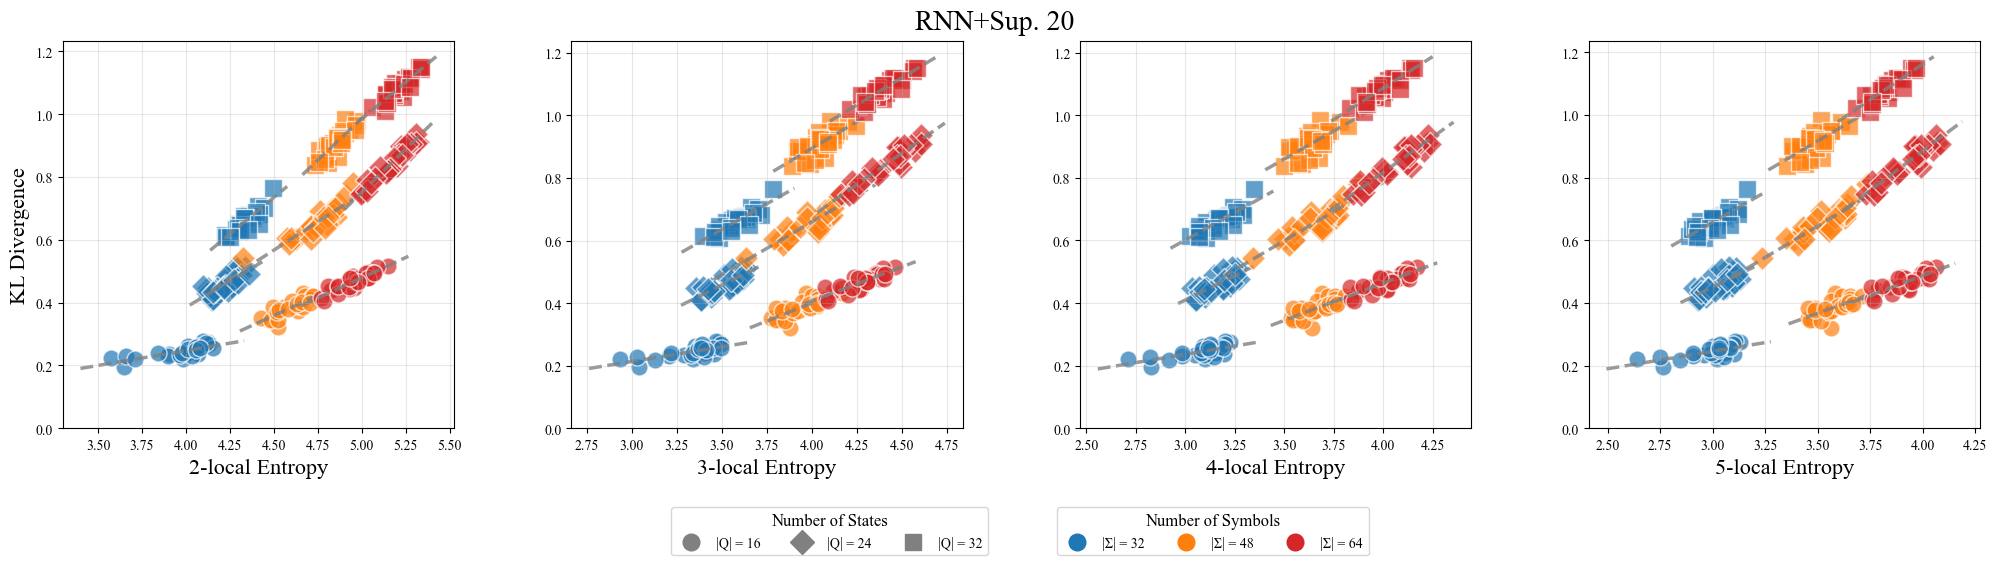

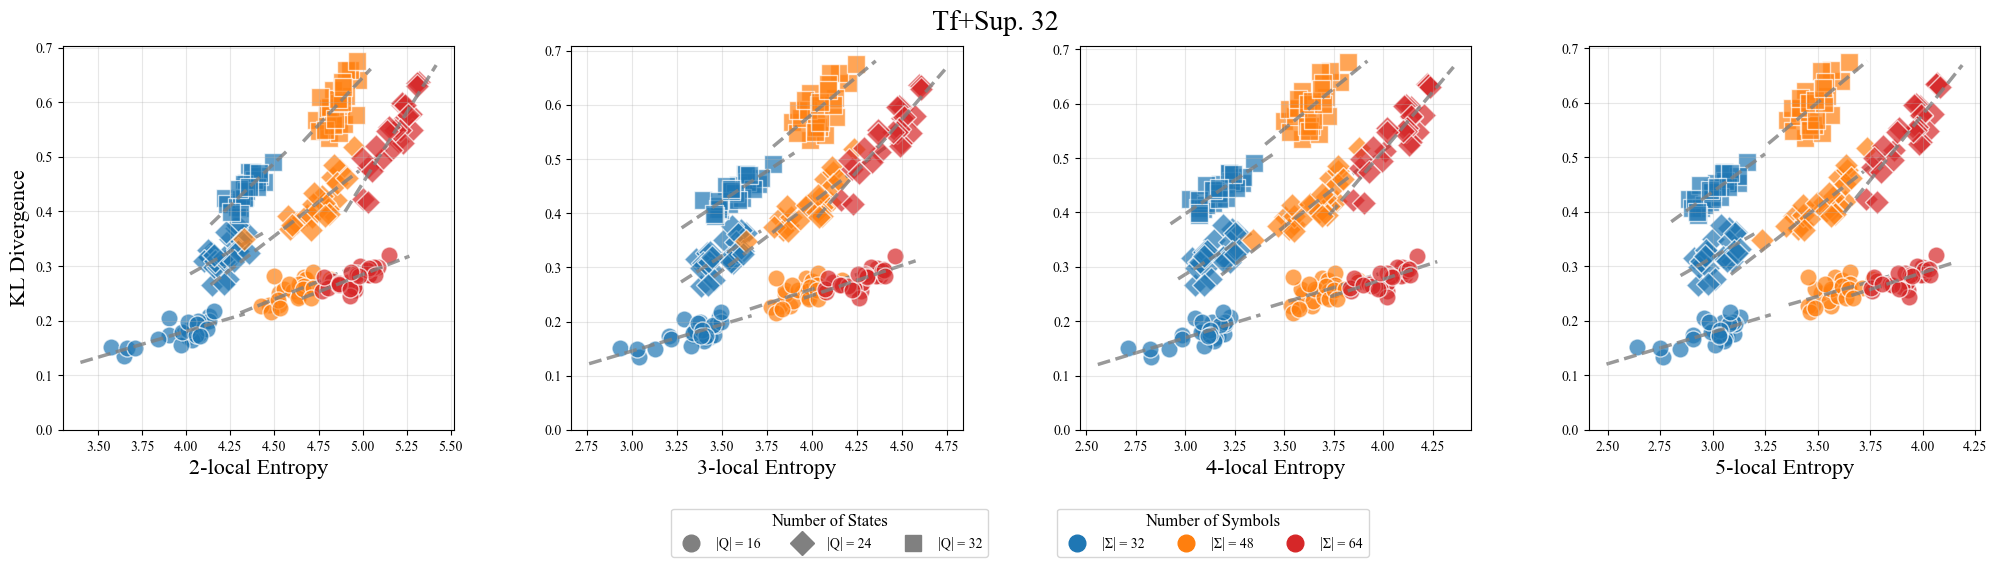

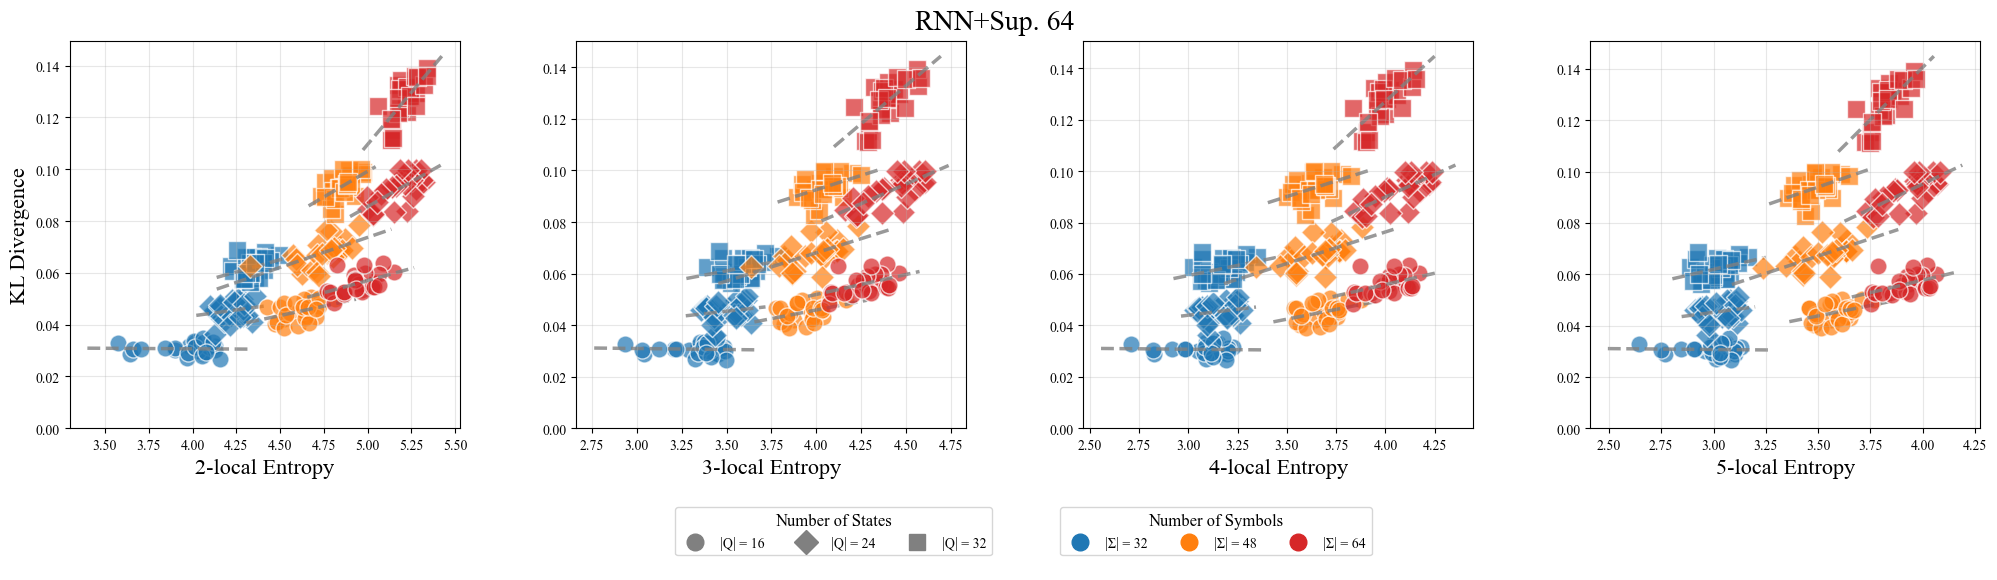

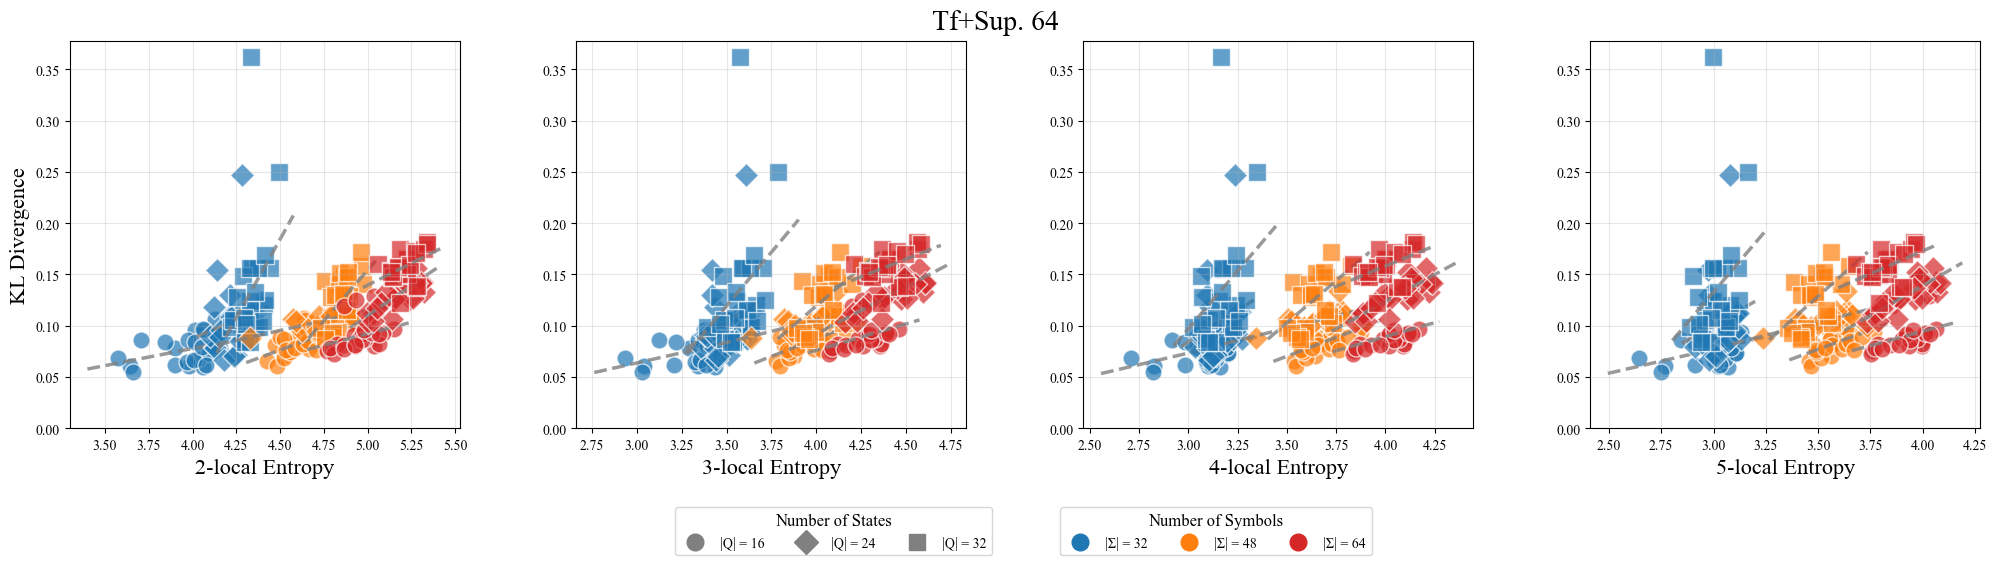

In [2]:
# Get m values from column names
ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (
        col.endswith("_local_entropy")
        and not col.startswith("estimated_")
        and not "prefix" in col
    )
]

# Define markers and colors for different parameters

n_states_markers = {
    16: "o",  # 円
    24: "D",  # ダイヤモンド
    32: "s",  # 四角
}

n_sym_colors = {
    32: "#1f77b4",  # 濃い青
    48: "#ff7f0e",  # 濃い橙
    64: "#d62728",  # 濃い赤
}


for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    # キャンバスのサイズを調整
    fig = plt.figure(figsize=(5 * len(ms), 6))

    # グリッドを作成（2行1列）：上部にプロット、下部に凡例
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])

    # 上部のグリッドをさらにサブプロットに分割
    gs_top = gs[0].subgridspec(1, len(ms), wspace=0.3)
    axes = [fig.add_subplot(gs_top[0, i]) for i in range(len(ms))]

    for i, m in enumerate(ms):
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Plot points and regression lines for each combination
        for n_sym in n_sym_colors.keys():
            for n_states in n_states_markers.keys():
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    # Plot scatter points
                    axes[i].scatter(
                        data[f"{m}_local_entropy"],
                        data["KL_divergence"],
                        marker=n_states_markers[n_states],
                        color=n_sym_colors[n_sym],
                        s=150,
                        alpha=0.7,
                        edgecolor="white",
                        linewidth=1,
                    )

                    # Add regression line for this combination
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    axes[i].plot(
                        line_x,
                        line_y,
                        color="gray",  # 統一した色
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

        axes[i].set_xlabel(f"{m}-local Entropy", fontsize=16)
        axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(
            0,
        )

    # 下部のグリッドに凡例を配置
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")  # 軸を非表示に

    # Create legend elements
    state_markers = [
        plt.Line2D(
            [0],
            [0],
            marker=marker,
            color="gray",
            markerfacecolor="gray",
            markersize=12,
            linestyle="None",
            label=f"|Q| = {n_states}",
        )
        for n_states, marker in n_states_markers.items()
    ]

    sym_markers = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=color,
            markersize=12,
            linestyle="None",
            label=f"|Σ| = {n_sym}",
        )
        for n_sym, color in n_sym_colors.items()
    ]

    # Add legends side by side with horizontal arrangement of elements
    legend1 = legend_ax.legend(
        handles=state_markers,
        title="Number of States",
        loc="center",
        bbox_to_anchor=(0.4, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_states_markers),
    )
    legend_ax.add_artist(legend1)

    legend2 = legend_ax.legend(
        handles=sym_markers,
        title="Number of Symbols",
        loc="center",
        bbox_to_anchor=(0.6, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_sym_colors),
    )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.96)
    plt.tight_layout()
    plt.show()

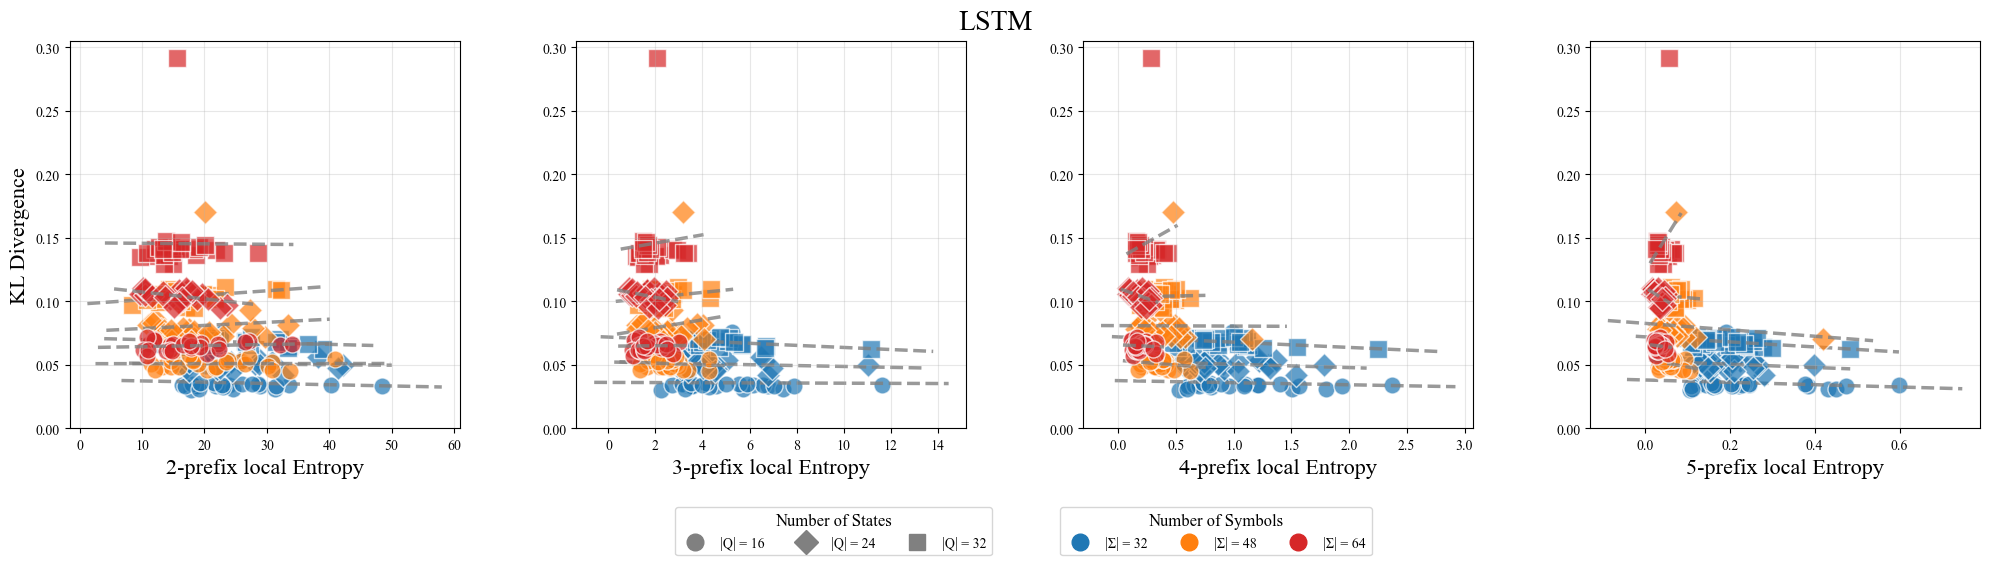

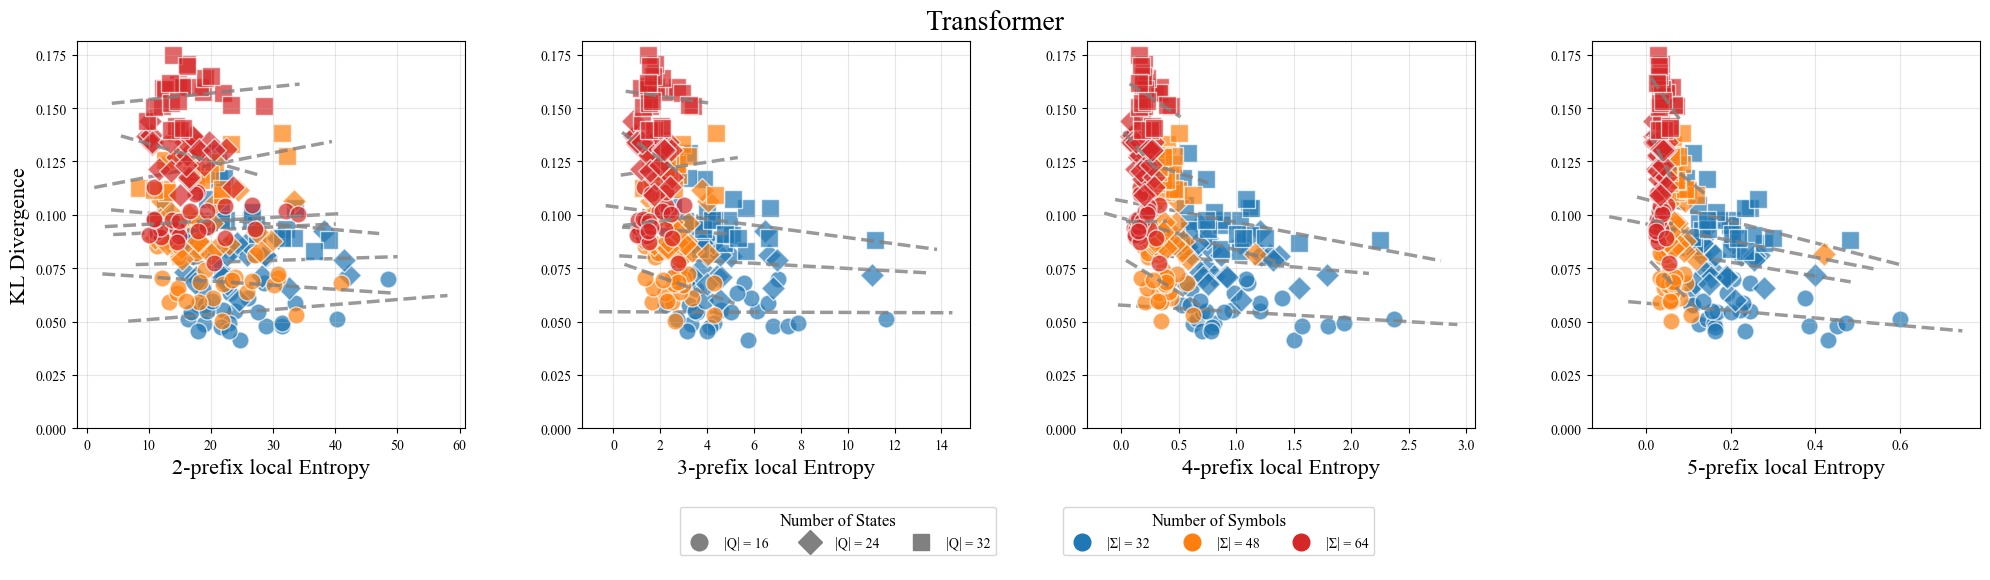

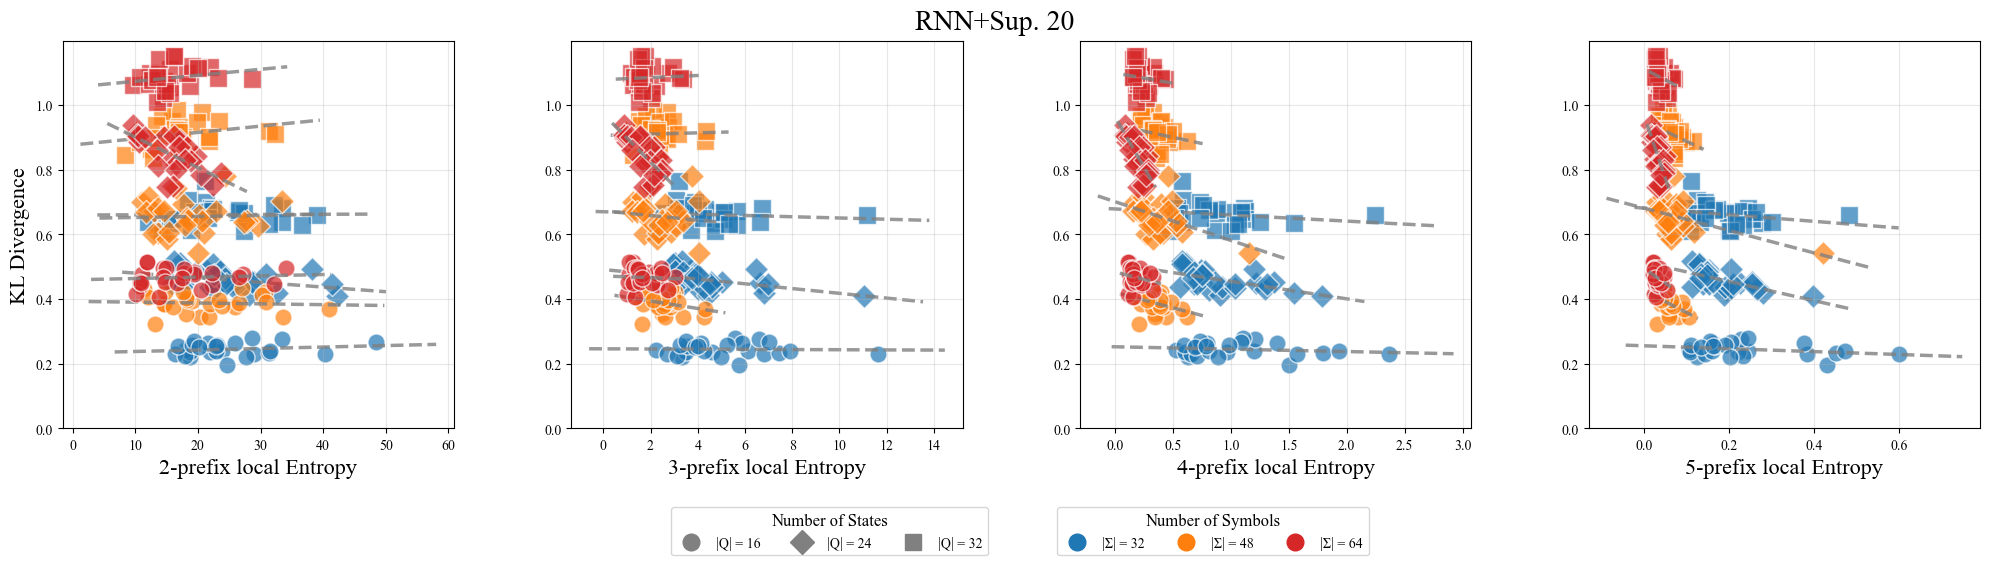

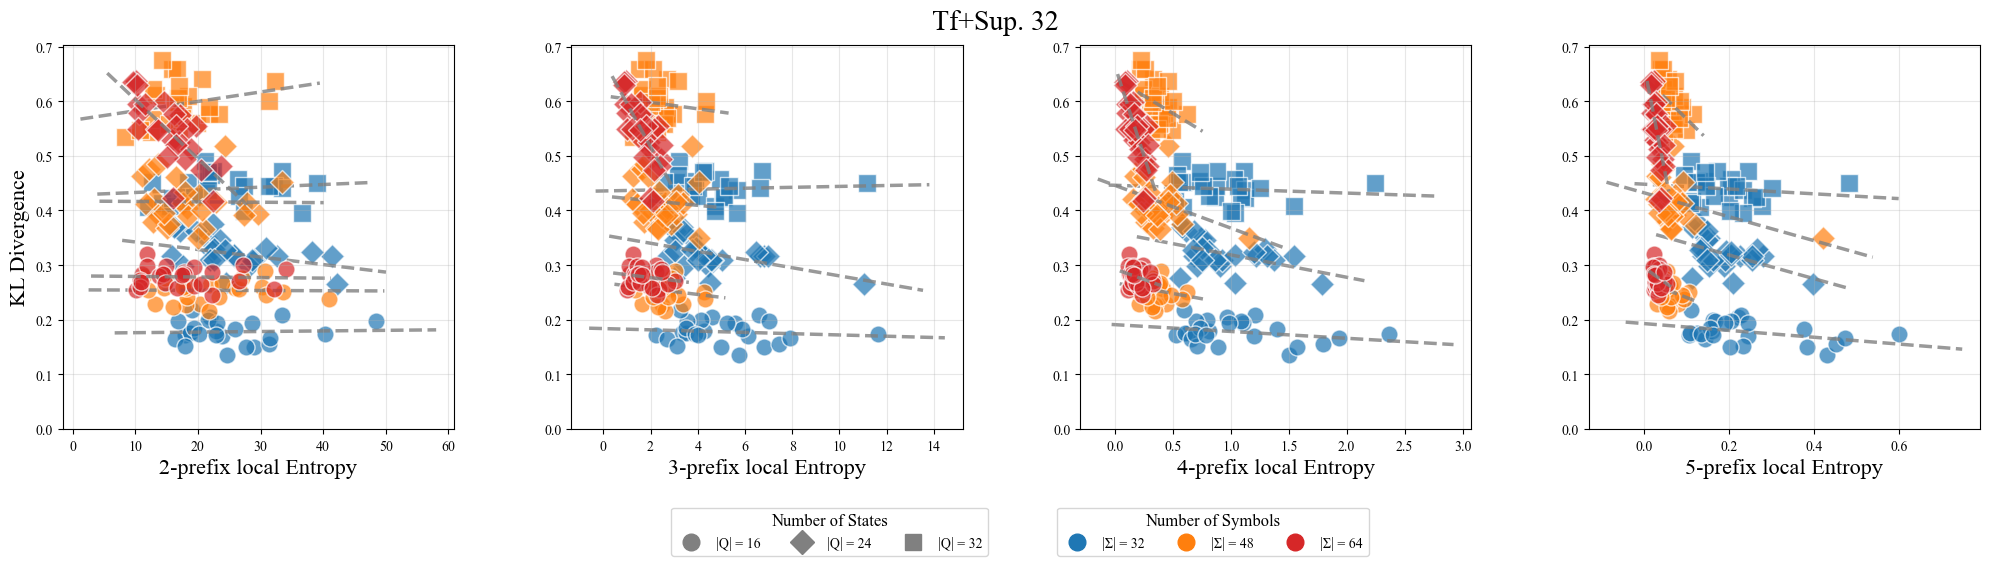

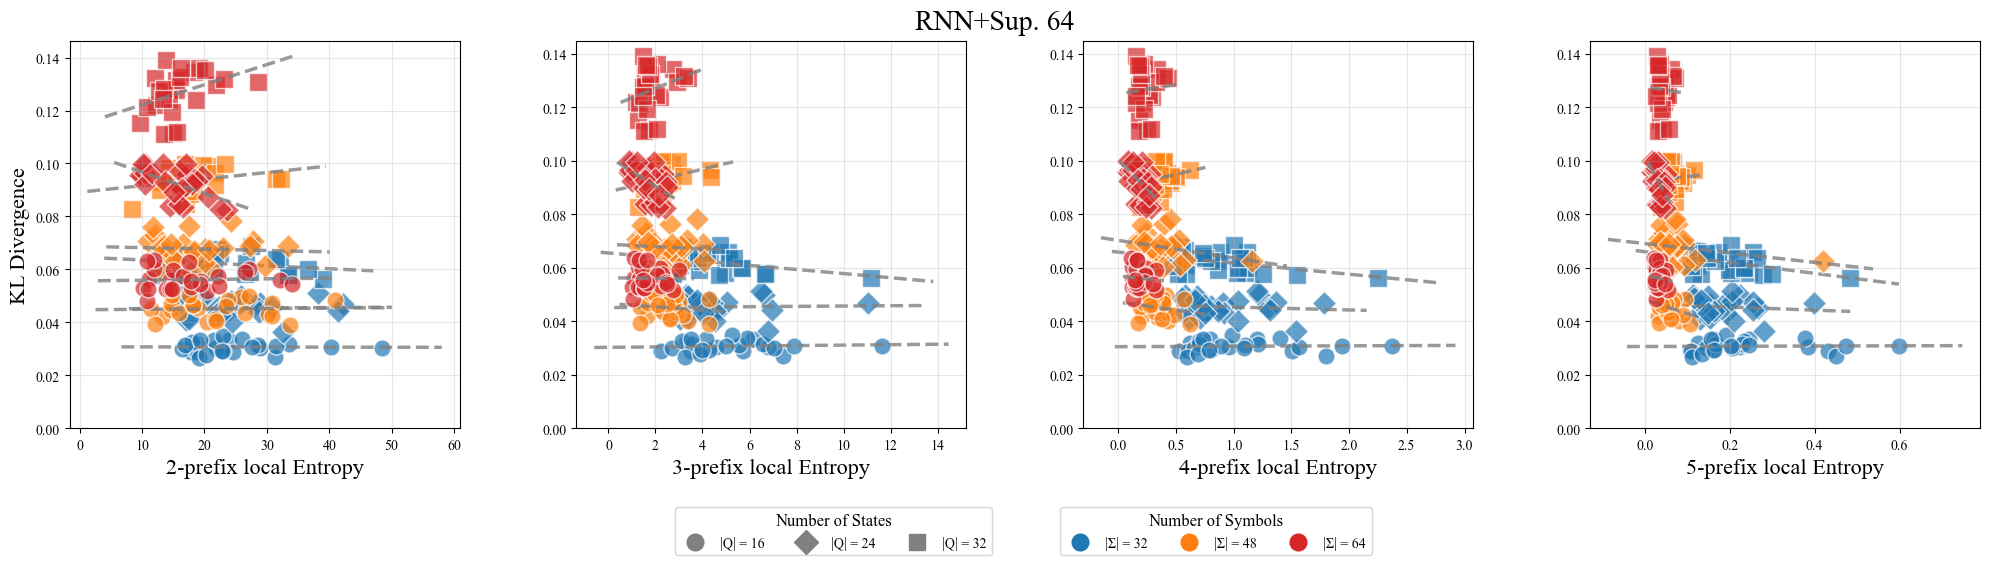

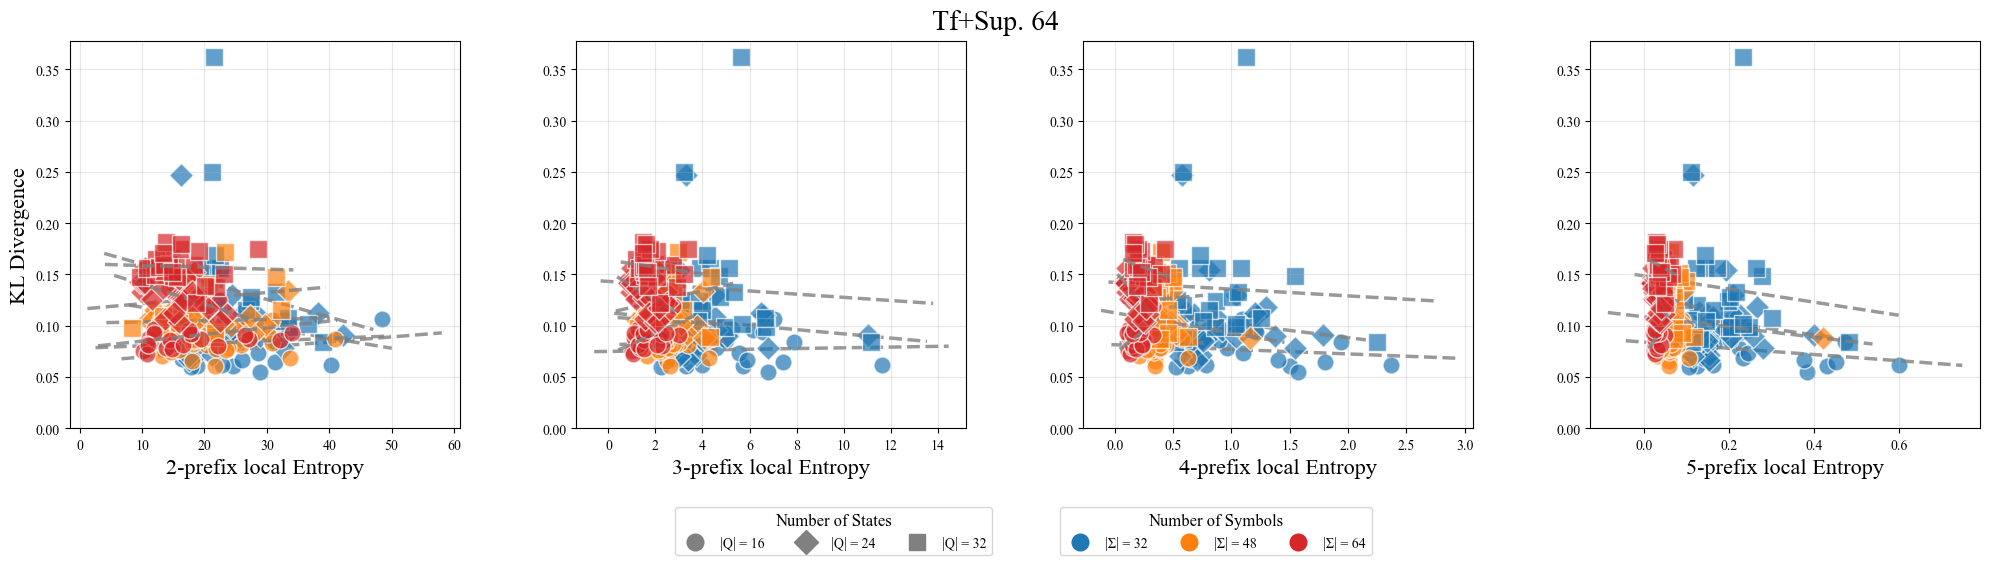

In [3]:
# prefixlocal entropy
# Get m values from column names
ms = [
    int(col.replace("_prefix_local_entropy", ""))
    for col in df.columns
    if (
        col.endswith("_prefix_local_entropy")
        and not col.startswith("estimated_")
        and "prefix" in col
    )
]

# Define markers and colors for different parameters

n_states_markers = {
    16: "o",  # 円
    24: "D",  # ダイヤモンド
    32: "s",  # 四角
}

n_sym_colors = {
    32: "#1f77b4",  # 濃い青
    48: "#ff7f0e",  # 濃い橙
    64: "#d62728",  # 濃い赤
}

for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    # キャンバスのサイズを調整
    fig = plt.figure(figsize=(5 * len(ms), 6))

    # グリッドを作成（2行1列）：上部にプロット、下部に凡例
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])

    # 上部のグリッドをさらにサブプロットに分割
    gs_top = gs[0].subgridspec(1, len(ms), wspace=0.3)
    axes = [fig.add_subplot(gs_top[0, i]) for i in range(len(ms))]

    for i, m in enumerate(ms):
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_prefix_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        # Plot points and regression lines for each combination
        for n_sym in n_sym_colors.keys():
            for n_states in n_states_markers.keys():
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    # Plot scatter points
                    axes[i].scatter(
                        data[f"{m}_prefix_local_entropy"],
                        data["KL_divergence"],
                        marker=n_states_markers[n_states],
                        color=n_sym_colors[n_sym],
                        s=150,
                        alpha=0.7,
                        edgecolor="white",
                        linewidth=1,
                    )

                    # Add regression line for this combination
                    x = data[f"{m}_prefix_local_entropy"]
                    y = data["KL_divergence"]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    axes[i].plot(
                        line_x,
                        line_y,
                        color="gray",  # 統一した色
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

        axes[i].set_xlabel(f"{m}-prefix local Entropy", fontsize=16)
        axes[i].set_ylabel("KL Divergence" if i == 0 else "", fontsize=16)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(
            0,
        )

    # 下部のグリッドに凡例を配置
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")  # 軸を非表示に

    # Create legend elements
    state_markers = [
        plt.Line2D(
            [0],
            [0],
            marker=marker,
            color="gray",
            markerfacecolor="gray",
            markersize=12,
            linestyle="None",
            label=f"|Q| = {n_states}",
        )
        for n_states, marker in n_states_markers.items()
    ]

    sym_markers = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=color,
            markersize=12,
            linestyle="None",
            label=f"|Σ| = {n_sym}",
        )
        for n_sym, color in n_sym_colors.items()
    ]

    # Add legends side by side with horizontal arrangement of elements
    legend1 = legend_ax.legend(
        handles=state_markers,
        title="Number of States",
        loc="center",
        bbox_to_anchor=(0.4, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_states_markers),
    )
    legend_ax.add_artist(legend1)

    legend2 = legend_ax.legend(
        handles=sym_markers,
        title="Number of Symbols",
        loc="center",
        bbox_to_anchor=(0.6, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_sym_colors),
    )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.96)
    plt.tight_layout()
    plt.show()

In [4]:
# Calculate R² values and create LaTeX table
results = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    for m in ms:
        model_data_mean = (
            model_data.groupby(["grammar_name", "N_sym", "n_states"])
            .agg(
                {
                    f"{m}_local_entropy": "mean",
                    "KL_divergence": "mean",
                }
            )
            .reset_index()
        )

        for n_sym in sorted(n_sym_colors.keys()):
            for n_states in sorted(n_states_markers.keys()):
                data = model_data_mean[
                    (model_data_mean["N_sym"] == n_sym)
                    & (model_data_mean["n_states"] == n_states)
                ]
                if not data.empty:
                    x = data[f"{m}_local_entropy"]
                    y = data["KL_divergence"]
                    _, _, r_value, _, _ = stats.linregress(x, y)
                    r_squared = r_value**2

                    results.append(
                        {
                            "Architecture": architecture_map[architecture],
                            "m": m,
                            "|Q|": n_states,
                            "|Σ|": n_sym,
                            "R²": r_squared,
                        }
                    )

results_df = pd.DataFrame(results)

# Create pivot table
pivot_df = results_df.pivot_table(
    index=["Architecture", "m"], columns=["|Q|", "|Σ|"], values="R²"
)

# Convert to LaTeX with specific formatting
latex_table = pivot_df.round(3).to_latex(
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    float_format=lambda x: f"{x:.3f}" if pd.notnull(x) else "",
)

# Print LaTeX table
print(latex_table)

\begin{tabular}{llrrrrrrrrr}
\toprule
 & |Q| & \multicolumn{3}{c}{16} & \multicolumn{3}{c}{24} & \multicolumn{3}{c}{32} \\
 & |Σ| & 32 & 48 & 64 & 32 & 48 & 64 & 32 & 48 & 64 \\
Architecture & m &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{\textbf{LSTM}} & \textbf{2} & 0.019 & 0.163 & 0.277 & 0.029 & 0.038 & 0.593 & 0.184 & 0.522 & 0.010 \\
\textbf{} & \textbf{3} & 0.030 & 0.180 & 0.255 & 0.058 & 0.054 & 0.620 & 0.195 & 0.393 & 0.007 \\
\textbf{} & \textbf{4} & 0.024 & 0.199 & 0.263 & 0.075 & 0.061 & 0.636 & 0.214 & 0.374 & 0.007 \\
\textbf{} & \textbf{5} & 0.022 & 0.205 & 0.273 & 0.075 & 0.063 & 0.629 & 0.227 & 0.380 & 0.008 \\
\cline{1-11}
\multirow[t]{4}{*}{\textbf{RNN+Sup. 20}} & \textbf{2} & 0.598 & 0.695 & 0.816 & 0.637 & 0.825 & 0.931 & 0.768 & 0.747 & 0.799 \\
\textbf{} & \textbf{3} & 0.525 & 0.615 & 0.728 & 0.653 & 0.798 & 0.897 & 0.793 & 0.557 & 0.807 \\
\textbf{} & \textbf{4} & 0.497 & 0.547 & 0.700 & 0.591 & 0.795 & 0.877 & 0.728 & 0.505 & 0.803 \\
\textbf{} & 

### XXX


In [5]:
# Compare variability of XXX and m local entropies using coefficient of variation (CV)
# CV = standard deviation / mean, allows comparison of variability between different scales
m_max = 5

# Calculate CV for XXX
XXX_cv = df["XXX"].std() / df["XXX"].mean()
print(f"XXX CV = {XXX_cv:.4f}")

# Calculate CV for each m local entropy
for m in range(2, m_max + 1):
    m_local_entropy_cv = (
        df[f"{m}_local_entropy"].std() / df[f"{m}_local_entropy"].mean()
    )
    print(f"m_local_entropy, m = {m}, CV = {m_local_entropy_cv:.4f}")

# Add statistical test to compare variances
from scipy import stats

# Perform Levene's test for equality of variances between XXX and each m_local_entropy
print("\nLevene's test for equality of variances (p-values):")
for m in range(2, m_max + 1):
    stat, p_value = stats.levene(df["XXX"], df[f"{m}_local_entropy"])
    print(f"XXX vs m_local_entropy (m={m}): p={p_value:.4f}")

XXX CV = 0.3456
m_local_entropy, m = 2, CV = 0.0897
m_local_entropy, m = 3, CV = 0.0996
m_local_entropy, m = 4, CV = 0.1058
m_local_entropy, m = 5, CV = 0.1086

Levene's test for equality of variances (p-values):
XXX vs m_local_entropy (m=2): p=0.0000
XXX vs m_local_entropy (m=3): p=0.0000
XXX vs m_local_entropy (m=4): p=0.0000
XXX vs m_local_entropy (m=5): p=0.0000


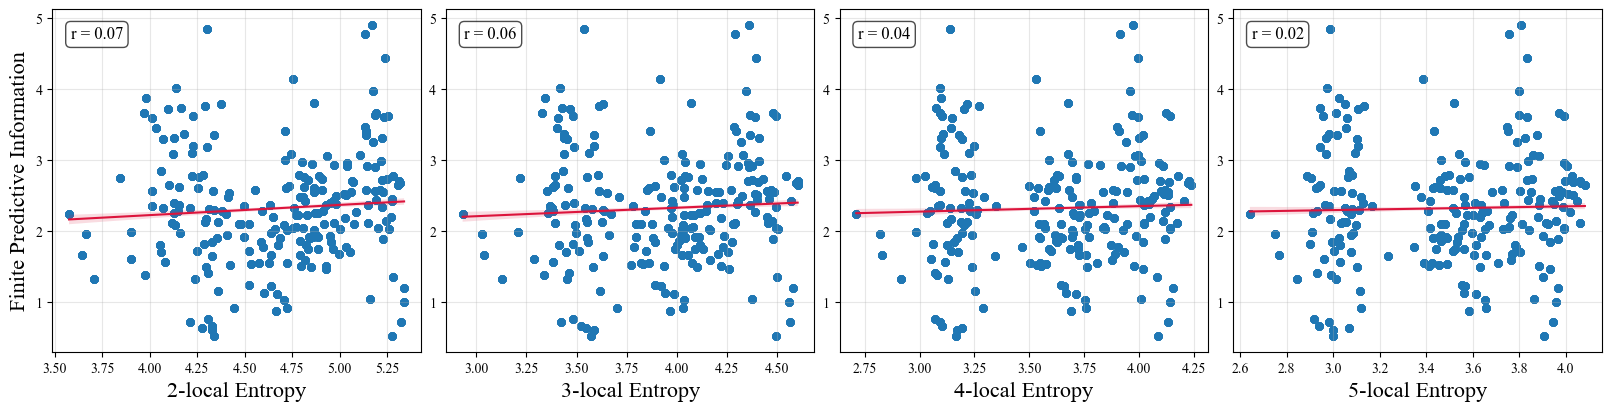

In [6]:
# Visualize the relationship between XXX and m–local entropy (m = 2 … 5)
# in a single-row figure with four panels (one for each m).

# import seaborn as sns
from scipy.stats import linregress

# sns.set_theme(style="whitegrid")

m_values = range(2, 6)  # m = 2, 3, 4, 5
fig, axes = plt.subplots(1, len(m_values), figsize=(16, 4), constrained_layout=True)

for ax, m in zip(axes, m_values):
    x_col = f"{m}_local_entropy"
    y_col = "XXX"

    # Remove rows with missing values for either variable
    subset = df[[x_col, y_col]].dropna()
    x, y = subset[x_col], subset[y_col]

    # Scatter plot + OLS regression line
    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        scatter_kws={"alpha": 0.7, "s": 25},
        line_kws={"color": "crimson", "linewidth": 1.5},
    )

    # Correlation statistics
    if len(subset) > 1:
        _, _, r_val, p_val, _ = linregress(x, y)
        # Add r value to the plot instead of title
        ax.text(
            0.05,
            0.95,
            f"r = {r_val:.2f}",
            transform=ax.transAxes,
            fontsize=12,
            va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )
    else:
        ax.text(
            0.05,
            0.95,
            "insufficient data",
            transform=ax.transAxes,
            fontsize=12,
            va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

    ax.set_xlabel(f"{m}-local Entropy", fontsize=16)
    if m == 2:
        ax.set_ylabel("Finite Predictive Information", fontsize=16)
    else:
        ax.set_ylabel("")
    ax.grid(True, alpha=0.3)

plt.show()

In [7]:
df = df[df["KL_divergence"] < 0.2]

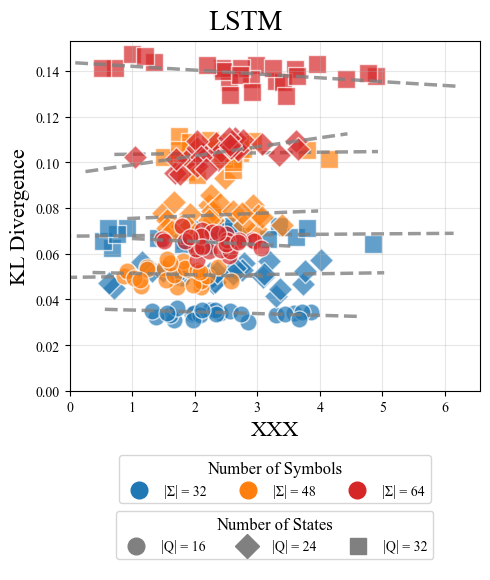

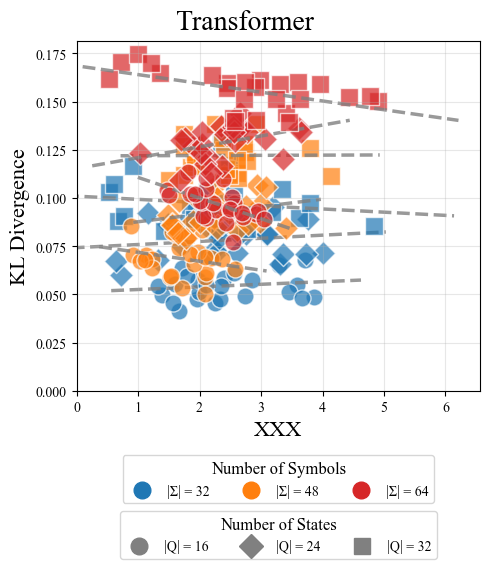

/Users/agiats/Projects/lm_inductive_bias/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/agiats/Projects/lm_inductive_bias/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/agiats/Projects/lm_inductive_bias/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10749: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


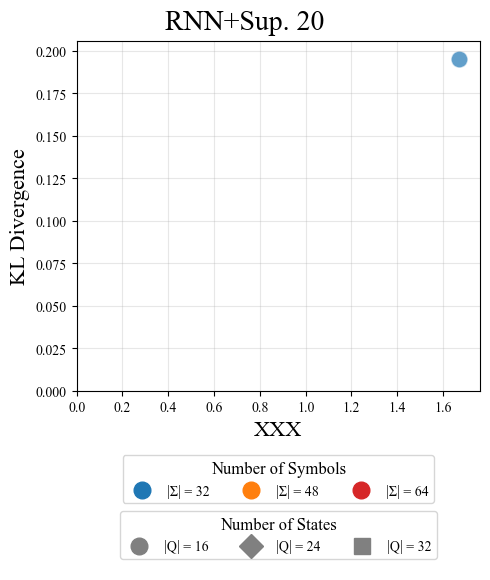

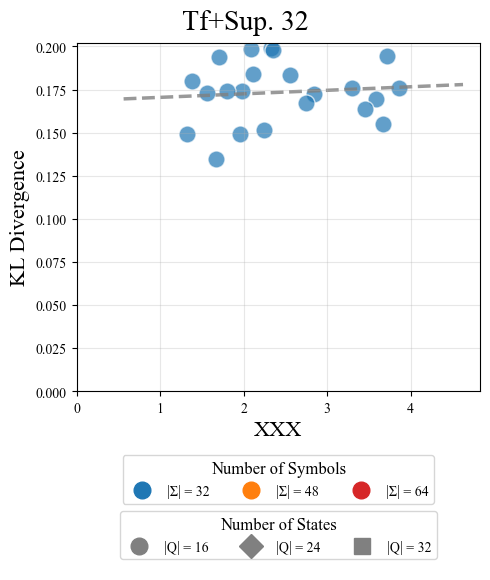

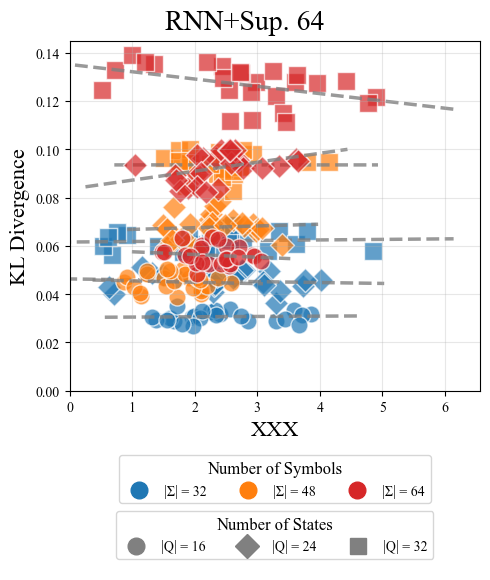

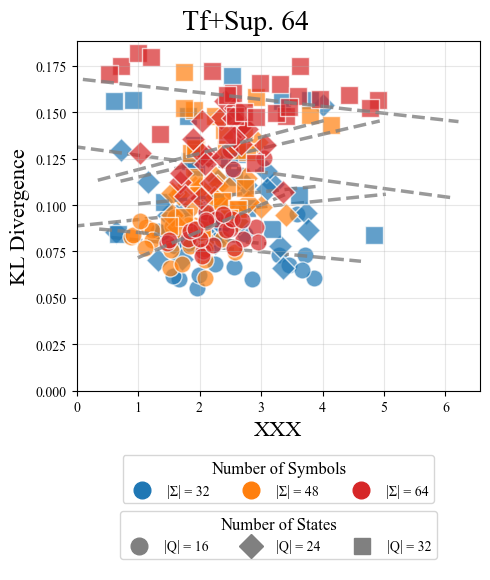

In [8]:
# Get XXX values from column names
# Define markers and colors for different parameters

n_states_markers = {
    16: "o",  # 円
    24: "D",  # ダイヤモンド
    32: "s",  # 四角
}

n_sym_colors = {
    32: "#1f77b4",  # 濃い青
    48: "#ff7f0e",  # 濃い橙
    64: "#d62728",  # 濃い赤
}

# XXX only configuraiton
# n_states_markers = {
#     50: "o",    # 円
#     100: "D",   # ダイヤモンド
#     150: "s",   # 四角

# }

# n_sym_colors = {
#     100: "#1f77b4",  # 濃い青
#     150: "#ff7f0e",  # 濃い橙
#     200: "#d62728",  # 濃い赤
# }


for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]

    # キャンバスのサイズを調整
    fig = plt.figure(figsize=(5, 6))

    # グリッドを作成（2行1列）：上部にプロット、下部に凡例
    gs = fig.add_gridspec(2, 1, height_ratios=[5, 1])

    # 上部のグリッドにプロットを配置
    ax = fig.add_subplot(gs[0])

    model_data_mean = (
        model_data.groupby(["grammar_name", "N_sym", "n_states"])
        .agg(
            {
                "XXX": "mean",
                "KL_divergence": "mean",
            }
        )
        .reset_index()
    )

    # Plot points and regression lines for each combination
    for n_sym in n_sym_colors.keys():
        for n_states in n_states_markers.keys():
            data = model_data_mean[
                (model_data_mean["N_sym"] == n_sym)
                & (model_data_mean["n_states"] == n_states)
            ]
            if not data.empty:
                # Plot scatter points
                ax.scatter(
                    data["XXX"],
                    data["KL_divergence"],
                    marker=n_states_markers[n_states],
                    color=n_sym_colors[n_sym],
                    s=150,
                    alpha=0.7,
                    edgecolor="white",
                    linewidth=1,
                )

                # Add regression line for this combination
                x = data["XXX"]
                y = data["KL_divergence"]
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                x_range = x.max() - x.min()
                line_x = np.array([x.min() - 0.3 * x_range, x.max() + 0.3 * x_range])
                line_y = slope * line_x + intercept
                ax.plot(
                    line_x,
                    line_y,
                    color="gray",  # 統一した色
                    linestyle="--",
                    alpha=0.8,
                    linewidth=2.5,
                    zorder=1,
                )

    ax.set_xlabel("XXX", fontsize=16)
    ax.set_ylabel("KL Divergence", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(
        0,
    )
    ax.set_xlim(
        0,
    )

    # 下部のグリッドに凡例を配置
    legend_ax = fig.add_subplot(gs[1])
    legend_ax.axis("off")  # 軸を非表示に

    # Create legend elements
    state_markers = [
        plt.Line2D(
            [0],
            [0],
            marker=marker,
            color="gray",
            markerfacecolor="gray",
            markersize=12,
            linestyle="None",
            label=f"|Q| = {n_states}",
        )
        for n_states, marker in n_states_markers.items()
    ]

    sym_markers = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=color,
            markersize=12,
            linestyle="None",
            label=f"|Σ| = {n_sym}",
        )
        for n_sym, color in n_sym_colors.items()
    ]

    # Add legends side by side with horizontal arrangement of elements
    legend1 = legend_ax.legend(
        handles=state_markers,
        title="Number of States",
        loc="center",
        bbox_to_anchor=(0.5, 0.5),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_states_markers),
    )
    legend_ax.add_artist(legend1)

    legend2 = legend_ax.legend(
        handles=sym_markers,
        title="Number of Symbols",
        loc="center",
        bbox_to_anchor=(0.5, 1.3),
        fontsize=10,
        title_fontsize=12,
        ncol=len(n_sym_colors),
    )

    plt.suptitle(f"{architecture_map[architecture]}", fontsize=20, y=0.96)
    plt.tight_layout()
    plt.show()

In [8]:
# Calculate R² values and create LaTeX table
from scipy.stats import pearsonr

results = []
for architecture in df["architecture"].unique():
    model_data = df[df["architecture"] == architecture]
    model_data_mean = (
        model_data.groupby(["grammar_name", "N_sym", "n_states"])
        .agg(
            {
                "XXX": "mean",
                "KL_divergence": "mean",
            }
        )
        .reset_index()
    )

    for n_sym in sorted(n_sym_colors.keys()):
        for n_states in sorted(n_states_markers.keys()):
            data = model_data_mean[
                (model_data_mean["N_sym"] == n_sym)
                & (model_data_mean["n_states"] == n_states)
            ]
            if not data.empty:
                x = data["XXX"]
                y = data["KL_divergence"]
                if len(x) > 1 and len(y) > 1:
                    r_value, _ = pearsonr(x, y)
                    r_squared = r_value**2
                else:
                    r_squared = float("nan")

                results.append(
                    {
                        "Architecture": architecture_map[architecture],
                        "|Q|": n_states,
                        "|Σ|": n_sym,
                        "R²": r_squared,
                    }
                )

results_df = pd.DataFrame(results)

# Create pivot table
pivot_df = results_df.pivot_table(
    index=["Architecture"], columns=["|Q|", "|Σ|"], values="R²"
)

# Convert to LaTeX with specific formatting and all columns centered
latex_table = pivot_df.round(3).to_latex(
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    float_format=lambda x: f"{x:.3f}" if pd.notnull(x) else "",
    column_format="c" * (pivot_df.shape[1] + 1),  # +1 for the index column
)

# Print LaTeX table
print(latex_table)

\begin{tabular}{cccccccccc}
\toprule
|Q| & \multicolumn{3}{c}{16} & \multicolumn{3}{c}{24} & \multicolumn{3}{c}{32} \\
|Σ| & 32 & 48 & 64 & 32 & 48 & 64 & 32 & 48 & 64 \\
Architecture &  &  &  &  &  &  &  &  &  \\
\midrule
\textbf{LSTM} & 0.052 & 0.007 & 0.022 & 0.009 & 0.000 & 0.281 & 0.005 & 0.002 & 0.002 \\
\textbf{RNN+Sup. 20} & 0.002 & 0.134 & 0.173 & 0.054 & 0.038 & 0.138 & 0.028 & 0.003 & 0.304 \\
\textbf{RNN+Sup. 64} & 0.002 & 0.006 & 0.014 & 0.010 & 0.006 & 0.161 & 0.004 & 0.000 & 0.194 \\
\textbf{Tf+Sup. 32} & 0.002 & 0.139 & 0.303 & 0.043 & 0.000 & 0.135 & 0.000 & 0.056 & NaN \\
\textbf{Tf+Sup. 64} & 0.031 & 0.015 & 0.166 & 0.022 & 0.028 & 0.082 & 0.124 & 0.039 & 0.098 \\
\textbf{Transformer} & 0.021 & 0.057 & 0.305 & 0.027 & 0.059 & 0.161 & 0.024 & 0.000 & 0.303 \\
\bottomrule
\end{tabular}



## main figure


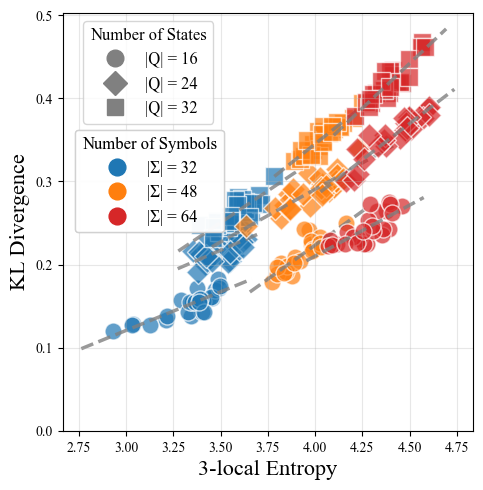

In [76]:
# Get m values from column names
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

architecture = "transformer"
m = 3

ms = [
    int(col.replace("_local_entropy", ""))
    for col in df.columns
    if (col.endswith("_local_entropy") and not col.startswith("estimated_"))
]

# Define markers and colors for different parameters
n_states_markers = {
    16: "o",  # Circle
    24: "D",  # Diamond
    32: "s",  # Square
}

n_sym_colors = {
    32: "#1f77b4",  # Dark Blue
    48: "#ff7f0e",  # Dark Orange
    64: "#d62728",  # Dark Red
}

model_data = df[df["architecture"] == architecture]

model_data_mean = (
    model_data.groupby(["grammar_name", "N_sym", "n_states"])
    .agg(
        {
            f"{m}_local_entropy": "mean",
            "KL_divergence": "mean",
        }
    )
    .reset_index()
)

plt.figure(figsize=(5, 5))

# Plot points and regression lines for each combination
for n_sym in n_sym_colors.keys():
    for n_states in n_states_markers.keys():
        data = model_data_mean[
            (model_data_mean["N_sym"] == n_sym)
            & (model_data_mean["n_states"] == n_states)
        ]
        if not data.empty:
            # Calculate IQR for KL_divergence
            Q1_y, Q3_y = np.percentile(data["KL_divergence"], [25, 75])
            IQR_y = Q3_y - Q1_y
            lower_bound_y = Q1_y - 1.5 * IQR_y
            upper_bound_y = Q3_y + 1.5 * IQR_y

            # Filter out outliers
            mask = (data["KL_divergence"] >= lower_bound_y) & (
                data["KL_divergence"] <= upper_bound_y
            )
            filtered_data = data[mask]

            if not filtered_data.empty:
                # Plot scatter points
                plt.scatter(
                    filtered_data[f"{m}_local_entropy"],
                    filtered_data["KL_divergence"],
                    marker=n_states_markers[n_states],
                    color=n_sym_colors[n_sym],
                    s=150,
                    alpha=0.7,
                    edgecolor="white",
                    linewidth=1,
                )

                # Add regression line for this combination
                x = filtered_data[f"{m}_local_entropy"]
                y = filtered_data["KL_divergence"]
                if len(x) > 2:  # Need at least 3 points for meaningful regression
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    x_range = x.max() - x.min()
                    line_x = np.array(
                        [x.min() - 0.3 * x_range, x.max() + 0.3 * x_range]
                    )
                    line_y = slope * line_x + intercept
                    plt.plot(
                        line_x,
                        line_y,
                        color="gray",
                        linestyle="--",
                        alpha=0.8,
                        linewidth=2.5,
                        zorder=1,
                    )

state_markers = [
    plt.Line2D(
        [0],
        [0],
        marker=marker,
        color="gray",
        markerfacecolor="gray",
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Q| = {n_states}",
    )
    for n_states, marker in n_states_markers.items()
]

sym_markers = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color=color,
        markersize=12,  # Smaller marker size
        linestyle="None",
        label=f"|Σ| = {n_sym}",
    )
    for n_sym, color in n_sym_colors.items()
]

# Add legends inside the figure ensuring they don't overlap
legend1 = plt.legend(
    handles=state_markers,
    title="Number of States",
    loc="upper left",
    bbox_to_anchor=(0.03, 1),
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

legend2 = plt.legend(
    handles=sym_markers,
    title="Number of Symbols",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.74),  # Adjusted to prevent overlap
    fontsize=12,  # Smaller font size
    title_fontsize=12,  # Smaller title font size
    ncol=1,
)  # Set number of columns to 1

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.grid(True, alpha=0.3)
plt.xlabel(f"{m}-local Entropy", fontsize=16)
plt.ylabel("KL Divergence", fontsize=16)
# plt.title("Relationship between Local Entropy and KL Divergence", fontsize=18)  # Added figure title
plt.tight_layout()
plt.ylim(
    0,
)
plt.show()